In [2]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import scipy

# Exercise 1: Image inpainting

Load the image `img_bad.png` and restore it as well as you can.

**Remark**: if you use `L-BFGS` for image processing, it may be a good idea to set the tolerance to a low value i.e. to use the option `tol=10**-8` or something of that order

(-0.5, 511.5, 341.5, -0.5)

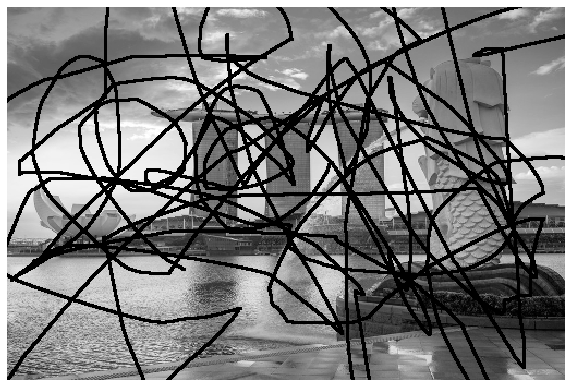

In [105]:
#load image
path_img = "img_bad.png"
im = onp.array(imageio.imread(path_img).astype(float)) / 255.
#display
plt.figure(figsize=(10,10))
plt.imshow(im, cmap="gray")
plt.axis("off")

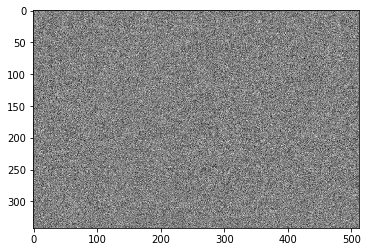

In [106]:
h, w = im.shape
r = 100
U_init = onp.random.normal(0,1,size=(h,r)) / onp.sqrt(w*r)
V_init = onp.random.normal(0,1,size=(r,w)) / onp.sqrt(h*r)

plt.imshow(U_init@V_init, cmap="gray")

In [107]:
def loss(U,V):
    return np.mean((im - U@V)**2)

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

In [108]:
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(r,w)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(r,w)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                tol=10**-8,
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    V_final = traj["x"].reshape(r,w)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(h,r)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(h,r)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                tol=10**-8,
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(h,r)
    return U_final

In [109]:
U,V = onp.copy(U_init), onp.copy(V_init)

In [110]:
LBFGS_iter = 5000
n_iter = 500
loss_history = []

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_history.append(loss(U,V))

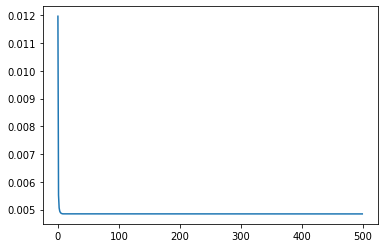

In [111]:
plt.plot(loss_history)

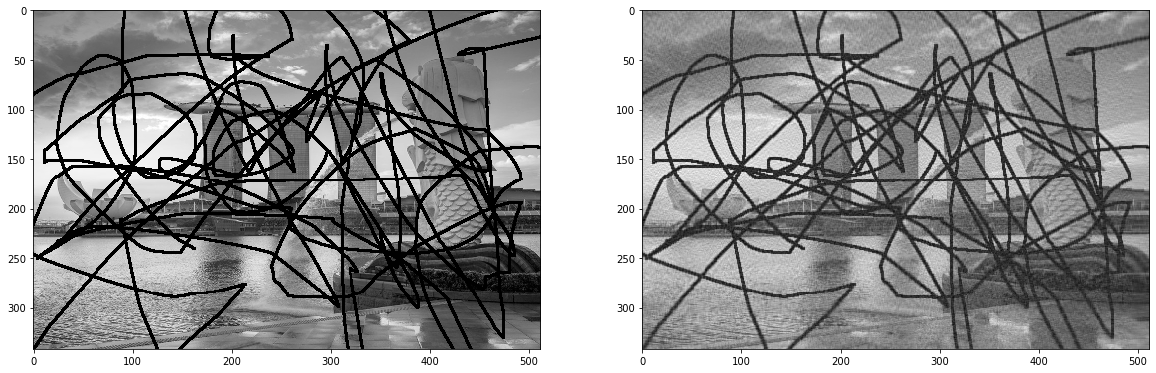

In [112]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(U@V, cmap="gray")